In [1]:
#강아지와 고양이 이미지에서 유용한 특성 추출
from keras.applications import VGG16
#include_top : 완전연결분류기를 포함할지
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [5]:
#데이터증식을 사용하지 않는 빠른 특성추출
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = 'C:/Users/Woody/Desktop/train'

#훈련,검증용 디렉토리 생성
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

#이미지와 레이블을 넘파이배열로 추출
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

#사전훈련된 합성곱 기반층 사용
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 생성, 중지필요
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 4s 29ms/step - loss: 0.6581 - acc: 0.6304 - val_loss: 0.4314 - val_acc: 0.8320
Epoch 2/30
100/100 [==============================] - 3s 26ms/step - loss: 0.4457 - acc: 0.7998 - val_loss: 0.3616 - val_acc: 0.8540
Epoch 3/30
100/100 [==============================] - 3s 33ms/step - loss: 0.3718 - acc: 0.8382 - val_loss: 0.3307 - val_acc: 0.8620
Epoch 4/30
100/100 [==============================] - 4s 38ms/step - loss: 0.3241 - acc: 0.8581 - val_loss: 0.3054 - val_acc: 0.8720
Epoch 5/30
100/100 [==============================] - 4s 37ms/step - loss: 0.3058 - acc: 0.8723 - val_loss: 0.2797 - val_acc: 0.8950
Epoch 6/30
100/100 [==============================] - 3s 32ms/step - loss: 0.2698 - acc: 0.8901 - val_loss: 0.2693 - val_acc: 0.8970
Epoch 7/30
100/100 [==============================] - 3s 33ms/step - loss: 0.2513 - acc: 0.9064 - val_loss: 0.2637 - val_acc: 0.9020
Epoch 8/30
100/100 [==============================] - 3s 29ms/step - 

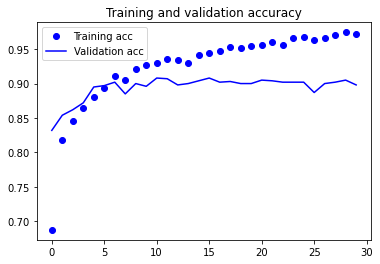

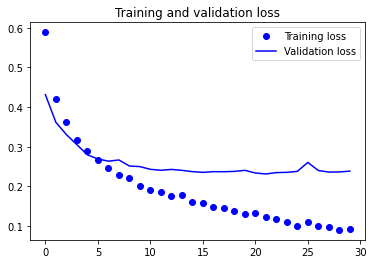

In [9]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
#데이터 증식을 사용한 특성 추출
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [12]:
#합성곱 기반층을 동결하지 않으면 사전에 학습된 표현이 훈련하는동안 수정됨
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [13]:
conv_base.trainable = False

In [14]:
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=20,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # 타깃 디렉터리
        train_dir,
        # 모든 이미지의 크기를 150 × 150로 변경
        target_size=(150, 150),
        batch_size=20,
        # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/15
100/100 - 370s - loss: 0.4348 - acc: 0.8245 - val_loss: 0.3487 - val_acc: 0.8770
Epoch 2/15
100/100 - 393s - loss: 0.3701 - acc: 0.8480 - val_loss: 0.3100 - val_acc: 0.8870
Epoch 3/15
100/100 - 393s - loss: 0.3274 - acc: 0.8590 - val_loss: 0.2839 - val_acc: 0.8960
Epoch 4/15
100/100 - 430s - loss: 0.3055 - acc: 0.8745 - val_loss: 0.2690 - val_acc: 0.8990
Epoch 5/15
100/100 - 442s - loss: 0.2939 - acc: 0.8780 - val_loss: 0.2734 - val_acc: 0.8960
Epoch 6/15
100/100 - 348s - loss: 0.2766 - acc: 0.8895 - val_loss: 0.2542 - val_acc: 0.9010
Epoch 7/15
100/100 - 305s - loss: 0.2745 - acc: 0.8840 - val_loss: 0.2465 - val_acc: 0.9030
Epoch 8/15
100/100 - 303s - loss: 0.2549 - acc: 0.8960 - val_loss: 0.2459 - val_acc: 0.9040
Epoch 9/15
100/100 - 304s - loss: 0.2544 - acc: 0.8995 - val_loss: 0.2458 - val_acc: 0.8990
Epoch 10/15
100/100 - 304s - loss: 0.2496 - acc: 0.8985 - val_loss: 0.2385 - val_acc: 0.

In [17]:
model.save('cats_and_dogs_small_3.h5')

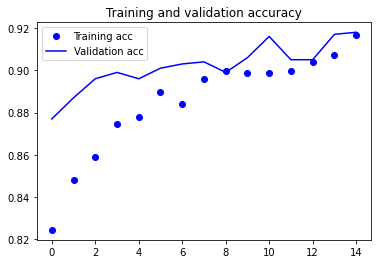

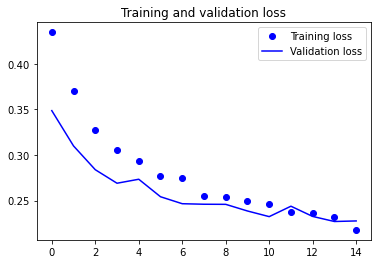

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [19]:
#미세조정

conv_base.trainable = True

#동결 여부
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [22]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/10
100/100 [==============================] - 353s 4s/step - loss: 0.2247 - acc: 0.9093 - val_loss: 0.1996 - val_acc: 0.9240
Epoch 2/10
100/100 [==============================] - 363s 4s/step - loss: 0.1614 - acc: 0.9312 - val_loss: 0.2256 - val_acc: 0.9190
Epoch 3/10
100/100 [==============================] - 344s 3s/step - loss: 0.1398 - acc: 0.9534 - val_loss: 0.1984 - val_acc: 0.9260
Epoch 4/10
100/100 [==============================] - 348s 3s/step - loss: 0.1218 - acc: 0.9495 - val_loss: 0.2003 - val_acc: 0.9260
Epoch 5/10
100/100 [==============================] - 345s 3s/step - loss: 0.0951 - acc: 0.9615 - val_loss: 0.2024 - val_acc: 0.9260
Epoch 6/10
100/100 [==============================] - 345s 3s/step - loss: 0.0807 - acc: 0.9710 - val_loss: 0.1870 - val_acc: 0.9360
Epoch 7/10
100/100 [==============================] - 343s 3s/step - loss: 0.0785 - acc: 0.9737 - val_loss: 0.1887 - val_acc: 0.9280
Epoch 8/10
100/100 [==============================] - 342s 3s/step - 

In [23]:
model.save('cats_and_dogs_small_4.h5')

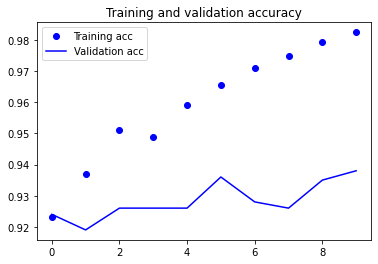

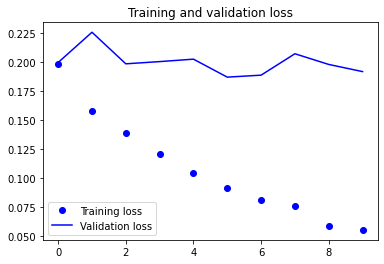

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

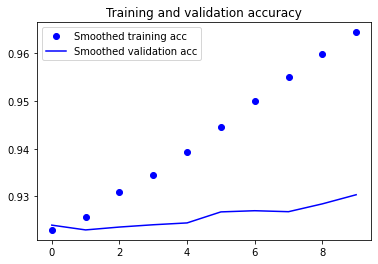

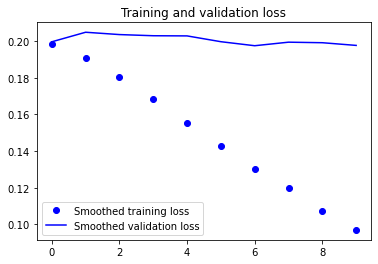

In [33]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


C:\Users\Woody\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9279999732971191
